# Accessing Dataset from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing Required Libraries

In [ ]:
!pip install  visualkeras
!pip3 install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 53.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=8beea0c853f5d3655cd86fbb57efb6eab1c823cc7e083a1d2e7f261aea870ff7
  Stored in directory: /root/.cache/pip/wheels/4b/ef/77/9b8c4ae2f9a11de19957b80bc5c684accd99114bb8dc6b374c
Successfully built ann_visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# LIBRARIES

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix
import visualkeras
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

# Data Preprocessing

In [ ]:
labels = ['COVID19','NORMAL','PNEUMONIA','TURBERCULOSIS','LUNGCANCER']

In [ ]:
X_full = []
y_full = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Defense/defense dataset/all clean',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size, image_size))
        X_full.append(img)
        y_full.append(i)
        
        
X_full = np.array(X_full)
y_full = np.array(y_full)

100%|██████████| 93/93 [01:57<00:00,  1.26s/it]


# Dividing the dataset as a Train & Test

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_full,y_full, test_size=0.2,random_state=101)

# Performing One Hot Encoding on the labels after converting it into numerical values

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# efficientNet

In [ ]:
efficientNet = tf.keras.applications.EfficientNetB0(
    include_top=False, 
    weights = 'imagenet', 
    input_shape=(224,224,3),
    )

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
efficientNet.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
  efficientNet,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(units=1024, activation='relu'),
  tf.keras.layers.Dense(units=512, activation='relu'),
  tf.keras.layers.Dense(units=5, activation='softmax'), 
])

# Compiling the Model

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 1024)              64226304  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 68,803,240
Trainable params: 64,753,669
No

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("CovidModelEfficientNet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',verbose=1)

# Training the Model

In [ ]:
hist = model.fit(X_train,
                 y_train,
                 validation_split=0.1, 
                 #epochs =15
                 epochs =30, 
                 verbose=1, 
                 batch_size=32,
                 #batch_size=16,
                  callbacks=[tensorboard,checkpoint,reduce_lr]
                 )

Epoch 1/30
163/163 [==============================] - ETA: 0s - loss: 0.9732 - accuracy: 0.8768
Epoch 1: val_accuracy improved from -inf to 0.95329, saving model to CovidModelEfficientNet.h5
163/163 [==============================] - 32s 120ms/step - loss: 0.9732 - accuracy: 0.8768 - val_loss: 0.1649 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9475
Epoch 2: val_accuracy did not improve from 0.95329
163/163 [==============================] - 13s 81ms/step - loss: 0.1549 - accuracy: 0.9475 - val_loss: 0.2071 - val_accuracy: 0.9446 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9491
Epoch 3: val_accuracy improved from 0.95329 to 0.95502, saving model to CovidModelEfficientNet.h5
163/163 [==============================] - 16s 100ms/step - loss: 0.1559 - accuracy: 0.9491 - val_loss: 0.1512 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 4/30
163/163 [========

# Accuracy of the Model

In [ ]:
results = model.evaluate(X_train,y_train)

181/181 [==============================] - 12s 65ms/step - loss: 0.0178 - accuracy: 0.9948


In [ ]:
results2 = model.evaluate(X_test,y_test)

46/46 [==============================] - 3s 69ms/step - loss: 0.1009 - accuracy: 0.9709


# Visualize of the Graph

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


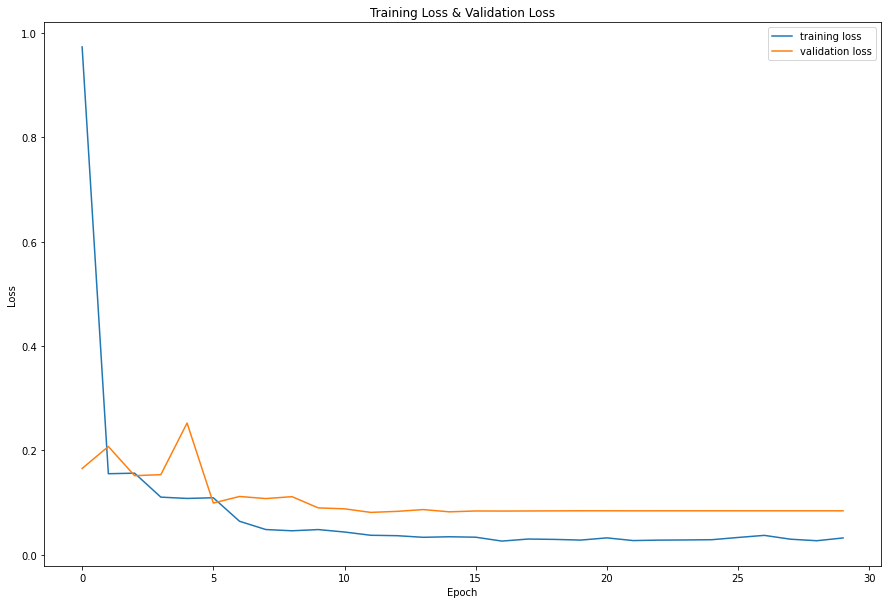

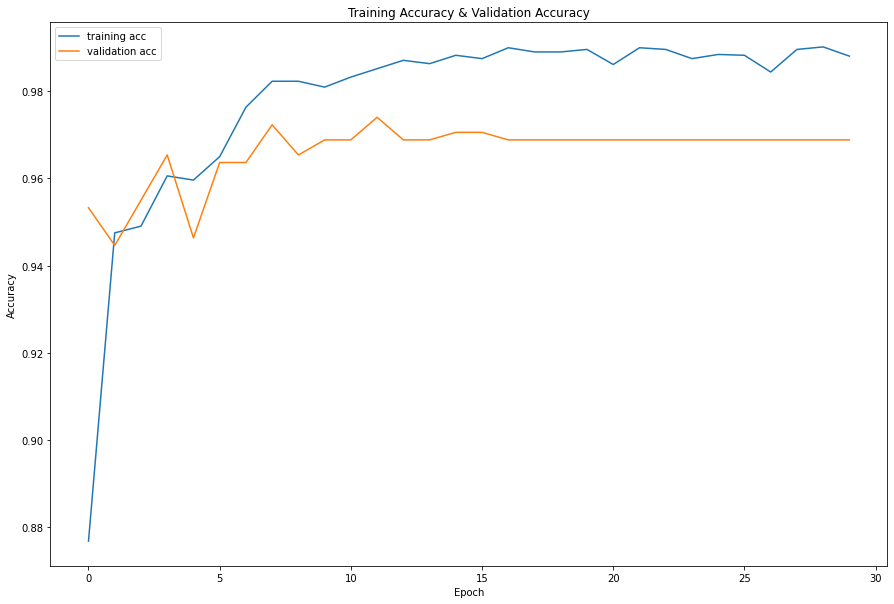

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(hist.history["loss"],label = "training loss")
plt.plot(hist.history["val_loss"],label = "validation loss")
plt.title("Training Loss & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(hist.history["accuracy"],label = "training acc")
plt.plot(hist.history["val_accuracy"],label = "validation acc")
plt.title("Training Accuracy & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# CLASSIFICATION REPORT

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

46/46 [==============================] - 4s 58ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       114
           1       0.94      0.94      0.94       315
           2       0.98      0.98      0.98       859
           3       0.98      1.00      0.99       146
           4       1.00      1.00      1.00        11

    accuracy                           0.97      1445
   macro avg       0.98      0.98      0.98      1445
weighted avg       0.97      0.97      0.97      1445



# CONFUSION MATRIX

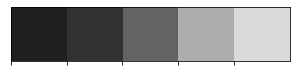

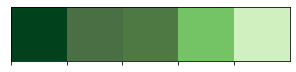

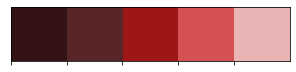

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

[[109   0   2   3   0]
 [  0 297  18   0   0]
 [  0  19 840   0   0]
 [  0   0   0 146   0]
 [  0   0   0   0  11]]


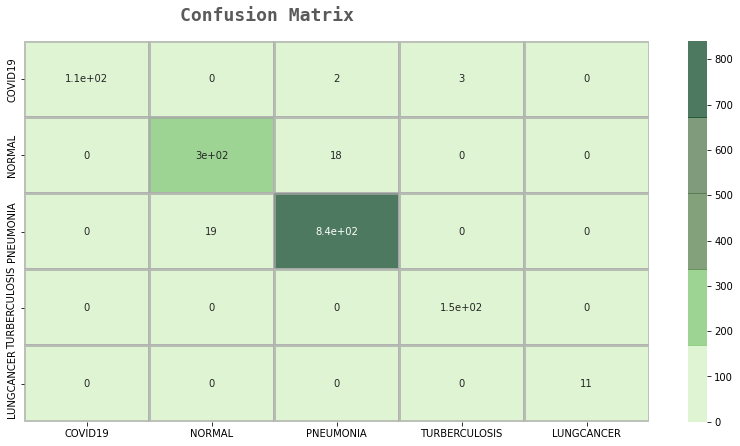

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))

sns.heatmap(confusion_matrix(y_test_new,pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,
            linewidths=2,
            linecolor=colors_dark[3]
            )

fig.text(s='Confusion Matrix',
         size=18,
         fontweight='bold',
         fontname='monospace',
         color=colors_dark[1],
         y=0.92,
         x=0.28,
         alpha=0.8)
print(confusion_matrix(y_test_new,pred))
plt.show()